In [1]:
import numpy as np
import pandas as pd
from botorch.test_functions.synthetic import Ackley, AckleyMixed, Labs, Griewank
import torch
from sklearn.decomposition import PCA
from tqdm import tqdm

import sys
sys.path.append('../')
from roelfes_emulator import RoelfesEmulator
from vae import Autoencoder, WeightedAutoencoder
from bayesian_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import gc
from joblib import Parallel, delayed

c:\Users\danin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_random_inputs(bounds, q, discrete_inds=None):
    lower, upper = bounds  
    generated_samples = lower + (upper - lower) * torch.rand((q, bounds.shape[1]))
    if discrete_inds is not None:
        generated_samples[:, discrete_inds] = torch.round(generated_samples[:, discrete_inds])
    return generated_samples

In [3]:
def bayes_opt_roelfes_coef(objs, q, q_sampling_method="Monte Carlo"):
    lin_y_names= ['y1','y2']
    dec_exp_y_names = ['y3','y4','y5','y6']
    all_names = lin_y_names + dec_exp_y_names

    lin_df = objs.drop(dec_exp_y_names,axis=1)
    dec_exp_df = objs.drop(lin_y_names, axis=1)

    q1 = q // 2
    q2 = q - q1
    if q == 1:
        q1 = 1

    lin_bo_model = BayesianOptimization().fit(lin_df, y=lin_y_names)
    c1 = lin_bo_model.candidates(q1, export_df=True, q_sampling_method=q_sampling_method)
    dec_exp_bo_model = BayesianOptimization().fit(dec_exp_df, y=dec_exp_y_names, 
                                                optim_direc=['max','max', 'min','max'])
    c2 = dec_exp_bo_model.candidates(q2, export_df=True,q_sampling_method=q_sampling_method)
    cand = pd.concat((c1, c2)).fillna(0)
    pred = cand[all_names].to_numpy()
    cand = cand.drop(all_names, axis=1).to_numpy()
    if q == 1:
        choice = np.random.randint(0,2)
        return cand[choice,:], pred[choice,:]
        
    return cand, pred

In [4]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

np.random.seed(42)

starting_samples_n = 96
bo_iter_amount = 25
gp_methods = ["HED","Single-Task GP", "Mixed Single-Task GP"]
optim_methods = ["Multi-Start"]
sampling_strategies = ["Monte Carlo", "Sequential"]
cv_amount = 5
q_list = [1, 2, 4, 16]

# Define your functions with names
function_list = [
    ("AckleyMixed", AckleyMixed(dim=53)),
    ("Labs", Labs(dim=50)),
]

# Define optimization directions
optim_direc_map = {
    "AckleyMixed": ["min"],
    "Labs": ["min"],
}

# Results storage
results = {}
data = {}

In [5]:
def run_single_experiment(function_name, function, optim_direc, weights,
                          cv_iter, x_np_backup, y_np_backup,
                          gp_model, optim_method,
                          q, q_method):
    from sklearn.metrics import mean_absolute_error

    x_np, y_np = x_np_backup.copy(), y_np_backup.copy()
    q_key = f"q{q}_{q_method or 'None'}"

    best_vals = []
    mae_pred_vals = []

    for bo_iter in range(bo_iter_amount):
        # Apply dimensionality reduction if specified

        x_cols = [f"x{i+1}" for i in range(x_np.shape[1])]
        if len(optim_direc) > 1:
            y_cols = [f"y{i+1}" for i in range(y_np.shape[1])]
        else:
            y_cols = ['y1']
            y_np = y_np.reshape(len(y_np), 1)
        cat_dims = [x_cols[ind] for ind in function.discrete_inds]

        df = pd.DataFrame(np.hstack([x_np, y_np]), columns=x_cols + y_cols)

        model = BayesianOptimization().fit(df, y_cols, optim_direc=optim_direc, cat_dims=cat_dims, model_type=gp_model)
        cand, pred = model.candidates(q, q_sampling_method=q_method, optim_method=optim_method)

        cand_tensor = torch.tensor(np.array(cand, dtype=np.float32))
        if q > 1:
            new_y = function(cand_tensor).numpy().reshape(q, len(optim_direc))
        else:
            new_y = function(cand_tensor).numpy()

        scalar_y = np.dot(new_y, weights.T) if len(weights) > 1 else new_y.flatten() * weights[0]
        best_vals.append(np.max(scalar_y))

        mae_pred_vals.append(mean_absolute_error(pred, new_y))

        x_np = np.vstack([x_np, cand])
        y_np = np.vstack([y_np, new_y])

    return {
        "function_name": function_name,
        "gp_model": gp_model,
        "optim_method": optim_method,
        "q_key": q_key,
        "x": x_np,
        "best_vals_all_folds": best_vals,
        "mae_vals_all_folds": mae_pred_vals,
    }

In [6]:
# Prepare parallel jobs
parallel_jobs = []

for function_name, function in tqdm(function_list):
    optim_direc = optim_direc_map[function_name]
    weights = np.array([1 if d == "max" else -1 for d in optim_direc])

    if function_name not in results:
        results[function_name] = {}
        data[function_name] = {}

    for cv_iter in range(cv_amount):
        X = generate_random_inputs(function.bounds, starting_samples_n, function.discrete_inds)
        y = function(X)

        x_np = X.numpy().astype(np.float32)
        y_np = y.numpy().astype(np.float32)
        x_np_backup, y_np_backup = x_np.copy(), y_np.copy()

        for gp_model in gp_methods:
            for optim_method in optim_methods:
                for q in q_list:
                    relevant_sampling_strategies = sampling_strategies if q > 1 else [None]
                    for q_method in relevant_sampling_strategies:
                        job = delayed(run_single_experiment)(
                            function_name=function_name,
                            function=function,
                            optim_direc=optim_direc,
                            weights=weights,
                            cv_iter=cv_iter,
                            x_np_backup=x_np_backup,
                            y_np_backup=y_np_backup,
                            gp_model=gp_model,
                            optim_method=optim_method,
                            q=q,
                            q_method=q_method
                        )
                        parallel_jobs.append(job)

# Batch execution parameters
batch_size = 16  # Adjust based on memory/CPU availability

for i in range(0, len(parallel_jobs), batch_size):
    batch = parallel_jobs[i:i + batch_size]
    outputs = Parallel(n_jobs=-1, verbose=10)(batch)

    for out in outputs:
        fn = out["function_name"]
        gp_mod = out["gp_model"]
        optim_method = out["optim_method"]
        qk = out["q_key"]

        if gp_mod not in results[fn]:
            results[fn][gp_mod] = {}
            data[fn][gp_mod] = {}
        if optim_method not in results[fn][gp_mod]:
            results[fn][gp_mod][optim_method] = {}
            data[fn][gp_mod][optim_method] = {}
        if qk not in results[fn][gp_mod][optim_method]:
            results[fn][gp_mod][optim_method][qk] = {
                "x": [],
                "best_vals_all_folds": [],
                "mae_vals_all_folds": [],
            }
            data[fn][gp_mod][optim_method][qk] = {}

        results[fn][gp_mod][optim_method][qk]["x"].append(out["x"])
        results[fn][gp_mod][optim_method][qk]["best_vals_all_folds"].append(out["best_vals_all_folds"])
        results[fn][gp_mod][optim_method][qk]["mae_vals_all_folds"].append(out["mae_vals_all_folds"])

    del outputs
    gc.collect()


100%|██████████| 2/2 [00:00<00:00, 89.40it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  3 out of 16 | elapsed:   39.8s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  5 out of 16 | elapsed:  1.7min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  7 out of 16 | elapsed:  2.1min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  9 out of 16 | elapsed:  2.4min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done 11 out of 16 | elapsed:  3.0min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done 13 out of 16 | elapsed:  5.9min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done 16 out of 16 | elapsed: 11.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  3 out of 16 | elapsed:  1.1min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  5 out of 16 | elapsed:  2.0min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  7 out of 16 | elapsed:  2.2min remaining:  2.8min
[Parallel(n_jobs=-1)

In [7]:
# Final aggregation
for fname in results:
    for gp_model in results[fname]:
        for optim_method in results[fname][gp_model]:
            for q_key in results[fname][gp_model][optim_method]:
                data[fname][gp_model][optim_method][q_key]["best_vals_avg"] = np.mean(
                    results[fname][gp_model][optim_method][q_key]["best_vals_all_folds"], axis=0)
                data[fname][gp_model][optim_method][q_key]["mae_vals_avg"] = np.mean(
                    results[fname][gp_model][optim_method][q_key]["mae_vals_all_folds"], axis=0)


In [8]:
import pickle

In [9]:
with open('second_experiment.pkl', 'wb') as f:
    pickle.dump(data, f)

In [10]:
import matplotlib.pyplot as plt
import itertools

def plot_bo_results_for_gp_models(data,
                                   fixed_params=None,
                                   plot_metric='best_vals_avg',
                                   show_legend=True,
                                   legend_loc='upper left'):
    fixed_params = fixed_params or {}

    # Infer keys
    function_names = [fixed_params.get('function_name')] if fixed_params.get('function_name') else list(data.keys())
    gp_models = set()
    optim_methods = set()
    q_keys = set()

    for fn in function_names:
        for gp in data.get(fn, {}):
            gp_models.add(gp)
            for opt in data[fn][gp]:
                optim_methods.add(opt)
                for qk in data[fn][gp][opt]:
                    q_keys.add(qk)

    # Parse q_keys into structured q + strategy
    q_strat_pairs = []
    for qk in q_keys:
        if qk.startswith("q"):
            try:
                q_val, strat = qk[1:].split("_", 1)
                q_strat_pairs.append((int(q_val), strat))
            except Exception:
                continue

    q_list = sorted(set(q for q, _ in q_strat_pairs))
    sampling_strategies = sorted(set(s for _, s in q_strat_pairs))

    # Build variation set
    vary_params = []
    for p, vals in [('function_name', function_names),
                    ('gp_model', sorted(gp_models)),
                    ('optim_method', sorted(optim_methods)),
                    ('q', q_list),
                    ('sampling_strategy', sampling_strategies)]:
        if fixed_params.get(p) is None:
            vary_params.append(p)

    plt.figure(figsize=(10, 6))

    for combo in itertools.product(*[
        function_names if p == 'function_name' else
        sorted(gp_models) if p == 'gp_model' else
        sorted(optim_methods) if p == 'optim_method' else
        q_list if p == 'q' else
        sampling_strategies
        for p in vary_params
    ]):
        params = fixed_params.copy()
        for i, p in enumerate(vary_params):
            params[p] = combo[i]

        fn = params['function_name']
        gp_model = params['gp_model']
        optim_method = params['optim_method']
        q = params['q']
        strat = params['sampling_strategy']
        q_key = f"q{q}_{strat}"

        try:
            result = data[fn][gp_model][optim_method][q_key]
            y = result.get(plot_metric)
            if y is None:
                continue
            x = range(1, len(y) + 1)

            label_parts = []
            if fixed_params.get("function_name") is None:
                label_parts.append(fn)
            if fixed_params.get("gp_model") is None:
                label_parts.append(gp_model)
            if fixed_params.get("optim_method") is None:
                label_parts.append(optim_method)
            if fixed_params.get("q") is None:
                label_parts.append(f"q={q}")
            if fixed_params.get("sampling_strategy") is None:
                label_parts.append(f"strat={strat}")

            label = ", ".join(label_parts)
            plt.plot(x, y, label=label)

        except KeyError:
            continue

    plt.xlabel('BO Iteration')
    ylabel = {
        'best_vals_avg': 'Average Best Value',
        'mae_vals_avg': 'Average MAE (Prediction)',
    }.get(plot_metric, plot_metric)
    plt.ylabel(ylabel)
    title_parts = [f"BO - {ylabel}"]
    for key in ['function_name', 'gp_model', 'optim_method', 'q', 'sampling_strategy']:
        if key in fixed_params:
            title_parts.append(f"{key}={fixed_params[key]}")
    plt.title(" | ".join(title_parts))

    if show_legend:
        plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc=legend_loc)
    plt.tight_layout()
    plt.show()


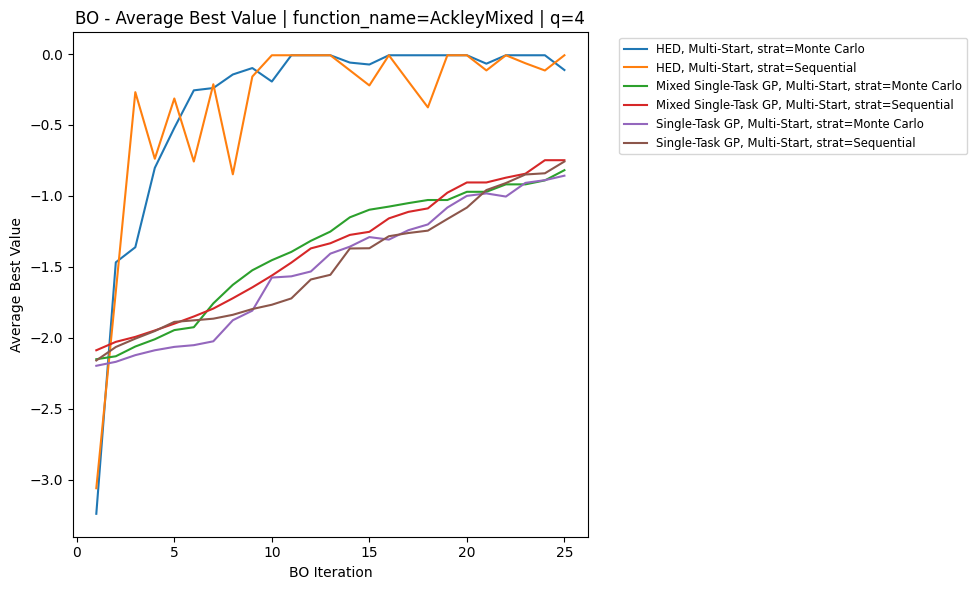

In [11]:
plot_bo_results_for_gp_models(data, fixed_params={
    "function_name": "AckleyMixed",
    "q": 4
})


from sklearn.metrics import mean_absolute_error

parallel_jobs = []

for function_name, function in tqdm(function_list):
    optim_direc = optim_direc_map[function_name]
    weights = np.array([1 if d == "max" else -1 for d in optim_direc])

    if function_name not in results:
        results[function_name] = {}
        data[function_name] = {}

    for cv_iter in range(cv_amount):
        X = generate_random_inputs(function.bounds, starting_samples_n, function.discrete_inds)
        y = function(X)

        x_np = X.numpy().astype(np.float32)
        y_np = y.numpy().astype(np.float32)
        x_np_backup, y_np_backup = x_np.copy(), y_np.copy()

        for gp_model in gp_methods:
            for optim_method in optim_methods:
                for q in q_list:
                    relevant_sampling_strategies = sampling_strategies if q > 1 else [None]
                    for q_method in relevant_sampling_strategies:

                        q_key = f"q{q}_{q_method or 'None'}"
                        x_np, y_np = x_np_backup.copy(), y_np_backup.copy()

                        best_vals = []
                        mae_pred_vals = []

                        for bo_iter in range(bo_iter_amount):
                            x_cols = [f"x{i+1}" for i in range(x_np.shape[1])]
                            if len(optim_direc) > 1:
                                y_cols = [f"y{i+1}" for i in range(y_np.shape[1])]
                            else:
                                y_cols = ['y1']
                                y_np = y_np.reshape(len(y_np), 1)
                            cat_dims = [x_cols[ind] for ind in function.discrete_inds]

                            df = pd.DataFrame(np.hstack([x_np, y_np]), columns=x_cols + y_cols)
                            print('fitting')
                            model = BayesianOptimization().fit(df, y_cols, optim_direc=optim_direc, cat_dims=cat_dims, model_type=gp_model)
                            print('fitdone')
                            print('canidat', bo_iter)
                            cand, pred = model.candidates(q, q_sampling_method=q_method, optim_method=optim_method)
                            print('canidone')
                            cand_tensor = torch.tensor(np.array(cand, dtype=np.float32))
                            if q > 1:
                                new_y = function(cand_tensor).numpy().reshape(q, len(optim_direc))
                            else:
                                new_y = function(cand_tensor).numpy()

                            scalar_y = np.dot(new_y, weights.T) if len(weights) > 1 else new_y.flatten() * weights[0]
                            best_vals.append(np.max(scalar_y))
                            mae_pred_vals.append(mean_absolute_error(pred, new_y))

                            x_np = np.vstack([x_np, cand])
                            y_np = np.vstack([y_np, new_y])

                        # Store results
                        if gp_model not in results[function_name]:
                            results[function_name][gp_model] = {}
                            data[function_name][gp_model] = {}
                        if optim_method not in results[function_name][gp_model]:
                            results[function_name][gp_model][optim_method] = {}
                            data[function_name][gp_model][optim_method] = {}
                        if q_key not in results[function_name][gp_model][optim_method]:
                            results[function_name][gp_model][optim_method][q_key] = {
                                "x": [],
                                "best_vals_all_folds": [],
                                "mae_vals_all_folds": [],
                            }
                            data[function_name][gp_model][optim_method][q_key] = {}

                        results[function_name][gp_model][optim_method][q_key]["x"].append(x_np)
                        results[function_name][gp_model][optim_method][q_key]["best_vals_all_folds"].append(best_vals)
                        results[function_name][gp_model][optim_method][q_key]["mae_vals_all_folds"].append(mae_pred_vals)

                        gc.collect()
